<a href="https://colab.research.google.com/github/sanjanagarai/Repository1/blob/main/Inter_IIT_ML_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libraries

In [ ]:
!pip install transformers
!pip install sentence_transformers

# Importing NLTK - natural Language Toolkit

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

# Importing other libraries and functions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### Loading the given dataset

In [ ]:
df = pd.read_csv('cgptsamples-1.csv')

Defining the model

In [ ]:
model_name = "bert-base-nli-mean-tokens"
model=SentenceTransformer(model_name)

##Exploratory Data Analysis

Understandig the data

In [ ]:
df.shape
df.nunique()

premise       317
hypothesis    309
label           1
dtype: int64

Clearly, there are duplicate hypothesis. We must now check if the duplicate hypothesis are relevant to their respective premises or not

In [ ]:
# Find duplicate 'hypothesis' values
duplicate_hypotheses = df[df.duplicated(subset='hypothesis', keep=False)]

# Print the rows with duplicate hypotheses
print(duplicate_hypotheses)

                                               premise  \
70   A sculptor is shaping a block of marble into a...   
71   A parent is helping their child fly a kite in ...   
72   A soccer player is dribbling the ball down the...   
76   A dancer is performing a graceful ballet routine.   
77   A barber is giving a customer a haircut at the...   
80   A group of friends is laughing and chatting ar...   
89   A sculptor is chiseling a piece of marble into...   
90   A parent is helping their child build a sandca...   
91   A soccer player is taking a penalty kick durin...   
95    A dancer is performing a lively hip-hop routine.   
96   A barber is giving a customer a stylish haircu...   
99   A group of friends is sharing stories around a...   
208  A group of psychologists is conducting studies...   
280  A team of artists is creating a public mural t...   
306  A team of psychologists is researching the eff...   
316  A group of artists is creating a series of pub...   

             

In [ ]:
#defining a function which returns the premises given a hypothesis
def find_premises_by_hypothesis(dataframe, target_hypothesis):
    premises = dataframe[dataframe['hypothesis'] == target_hypothesis]['premise'].tolist()
    return premises


Checking all the duplicate hypothesis to make sure there are no outliers


In [ ]:
#duplicate hypothesis1
target_hypothesis = 'Artistic sculpting is occurring.'
find_premises_by_hypothesis(df, target_hypothesis)


['A sculptor is shaping a block of marble into a statue.',
 'A sculptor is chiseling a piece of marble into a statue.']

Clearly, in this case, both the premises are relevant to the hypothesis

In [ ]:
#duplicate hypothesis2
target_hypothesis = 'Parent-child bonding is happening.'
find_premises_by_hypothesis(df, target_hypothesis)

['A parent is helping their child fly a kite in the park.',
 'A parent is helping their child build a sandcastle on the beach.']

In [ ]:
#duplicate hypothesis3
target_hypothesis = 'Soccer gameplay is occurring.'
find_premises_by_hypothesis(df, target_hypothesis)

['A soccer player is dribbling the ball down the field.',
 'A soccer player is taking a penalty kick during a match.']

Clearly, in this case, both the premises are relevant to the hypothesis

In [ ]:
#duplicate hypothesis4
target_hypothesis = 'Dance performance is happening.'
find_premises_by_hypothesis(df, target_hypothesis)

['A dancer is performing a graceful ballet routine.',
 'A dancer is performing a lively hip-hop routine.']

Clearly, in this case, both the premises are relevant to the hypothesis

In [ ]:
#duplicate hypothesis5
target_hypothesis = 'Haircutting service is provided.'
find_premises_by_hypothesis(df, target_hypothesis)

['A barber is giving a customer a haircut at the salon.',
 'A barber is giving a customer a stylish haircut at the salon.']

Clearly, in this case, both the premises are relevant to the hypothesis


In [ ]:
#duplicate hypothesis6
target_hypothesis = 'Socializing around the fire.'
find_premises_by_hypothesis(df, target_hypothesis)

['A group of friends is laughing and chatting around a campfire.',
 'A group of friends is sharing stories around a campfire.']

Clearly, in this case, both the premises are relevant to the hypothesis

In [ ]:
#duplicate hypothesis7
target_hypothesis = 'Nature-based mental health research.'
find_premises_by_hypothesis(df, target_hypothesis)

['A group of psychologists is conducting studies to explore the effects of nature exposure on mental well-being.',
 'A team of psychologists is researching the effects of spending time in natural environments on mental health.']

Clearly, in this case, both the premises are relevant to the hypothesis

In [ ]:
#duplicate hypothesis8
target_hypothesis = 'Cultural diversity mural project.'
find_premises_by_hypothesis(df, target_hypothesis)

['A team of artists is creating a public mural that celebrates the cultural heritage and diversity of a neighborhood.',
 'A group of artists is creating a series of public murals that celebrate cultural diversity and social unity.']

Clearly, in this case, both the premises are relevant to the hypothesis

In [ ]:
#checking for null values
df.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

## DATA AUGMENTATION


Negative sample generation function

STRATEGY USED: using **cosine similarity**, find 5 hypothesis that are least related to a particular premise (done for each and every premise) and append this pair to the original dataset with label 0 creating a new dataset - augmented_cgptsamples.csv

In [ ]:
#defining the function
def generate_negative_samples(df, model, sentence_vecs1, sentence_vecs2):
    negative_samples = []

    for i in range(len(df)):
      negative_samples.append((df['premise'][i], df['hypothesis'][i], 1))

    for premise_idx, premise in enumerate(df['premise']):
        premise_vec = sentence_vecs1[premise_idx].reshape(1, -1)
        hypothesis_vecs = sentence_vecs2

        # Compute cosine similarities between the premise and all hypotheses
        similarities = cosine_similarity(premise_vec, hypothesis_vecs)[0]

        # Find the indices of 5 hypotheses with the least similarity
        least_similar_indices = np.argpartition(similarities, 5)[:5]

        # Append these hypotheses to negative_samples with label 0
        for idx in least_similar_indices:
            negative_samples.append((premise, df['hypothesis'][idx], 0))

    return negative_samples


Performing negative sample generation on the dataset

In [ ]:
sentences1 = df['premise']
sentences2 = df['hypothesis']

sentences1 = model.encode(sentences1)
sentences2 = model.encode(sentences2)

# Generate negative samples
negative_samples = generate_negative_samples(df, model, sentences1, sentences2)

# Create a DataFrame from the negative_samples list
df_negative_samples = pd.DataFrame(negative_samples, columns=['premise', 'hypothesis', 'label'])

# Specify the output file path
output_file_path = 'augmented_cgptsamples.csv'

# Save the DataFrame to a CSV file
df_negative_samples.to_csv(output_file_path, index=False)

print(f"Negative samples saved to {output_file_path}")

Negative samples saved to augmented_cgptsamples.csv


# Split the new augmented datset into training set and testing set (80 % and 20 % respectively)

In [ ]:
# Load your dataset from 'augmented_cgptsamples.csv' (replace with your actual file path)
df = pd.read_csv('augmented_cgptsamples.csv')

# Split the dataset into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Identify common rows between train and test datasets
common_rows = pd.merge(train_df, test_df, on=['premise', 'hypothesis'], how='inner')

# Remove common rows from the test dataset
test_df = test_df[~test_df.index.isin(common_rows.index)]

# Save the train and test sets to CSV files
train_df.to_csv('train_dataset.csv', index=False)  # Save train dataset to 'train_dataset.csv'
test_df.to_csv('test_dataset.csv', index=False)    # Save updated test dataset to 'test_dataset.csv'


## TRAINING THE MODEL

Creating a CustomDataset class

In [ ]:
df = pd.read_csv('train_dataset.csv')

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        premise = str(self.data.loc[index, 'premise'])
        hypothesis = str(self.data.loc[index, 'hypothesis'])

        encoding = self.tokenizer.encode_plus(
            premise,
            hypothesis,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(self.data.loc[index, 'label'])
        }

## Hyperparameter Tuning (Using Grid Search)

Training with learning rate: 1e-05, batch size: 8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
Train Loss: 0.6161 | Train Accuracy: 0.6748
Validation Loss: 0.3718 | Validation Accuracy: 0.8818
*****************************************************
Epoch 2/5
Train Loss: 0.4009 | Train Accuracy: 0.8647
Validation Loss: 0.2496 | Validation Accuracy: 0.9694
*****************************************************
Epoch 3/5
Train Loss: 0.2813 | Train Accuracy: 0.9173
Validation Loss: 0.2776 | Validation Accuracy: 0.9781
*****************************************************
Epoch 4/5
Train Loss: 0.2239 | Train Accuracy: 0.9445
Validation Loss: 0.2384 | Validation Accuracy: 0.9759
*****************************************************
Epoch 5/5
Train Loss: 0.2086 | Train Accuracy: 0.9361
Validation Loss: 0.1865 | Validation Accuracy: 0.9847
*****************************************************
--------------------------------------------------------------------
Training with learning rate: 1e-05, batch size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train Loss: 0.6991 | Train Accuracy: 0.5677
Validation Loss: 0.5336 | Validation Accuracy: 0.8753
*****************************************************
Epoch 2/5
Train Loss: 0.4827 | Train Accuracy: 0.7829
Validation Loss: 0.2345 | Validation Accuracy: 0.9869
*****************************************************
Epoch 3/5
Train Loss: 0.2776 | Train Accuracy: 0.9417
Validation Loss: 0.1898 | Validation Accuracy: 0.9891
*****************************************************
Epoch 4/5
Train Loss: 0.1878 | Train Accuracy: 0.9727
Validation Loss: 0.1424 | Validation Accuracy: 1.0000
*****************************************************
Epoch 5/5
Train Loss: 0.1551 | Train Accuracy: 0.9868
Validation Loss: 0.1452 | Validation Accuracy: 0.9978
*****************************************************
--------------------------------------------------------------------
Training with learning rate: 1e-05, batch size: 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train Loss: 0.9663 | Train Accuracy: 0.3374
Validation Loss: 0.6168 | Validation Accuracy: 0.7330
*****************************************************
Epoch 2/5
Train Loss: 0.7010 | Train Accuracy: 0.5536
Validation Loss: 0.3917 | Validation Accuracy: 0.9694
*****************************************************
Epoch 3/5
Train Loss: 0.4576 | Train Accuracy: 0.8120
Validation Loss: 0.2853 | Validation Accuracy: 0.9869
*****************************************************
Epoch 4/5
Train Loss: 0.3150 | Train Accuracy: 0.9511
Validation Loss: 0.2712 | Validation Accuracy: 0.9912
*****************************************************
Epoch 5/5
Train Loss: 0.2439 | Train Accuracy: 0.9737
Validation Loss: 0.2143 | Validation Accuracy: 0.9934
*****************************************************
--------------------------------------------------------------------
Training with learning rate: 2e-05, batch size: 8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train Loss: 0.6501 | Train Accuracy: 0.6382
Validation Loss: 0.2506 | Validation Accuracy: 0.9759
*****************************************************
Epoch 2/5
Train Loss: 0.3072 | Train Accuracy: 0.8976
Validation Loss: 0.1660 | Validation Accuracy: 0.9912
*****************************************************
Epoch 3/5
Train Loss: 0.2512 | Train Accuracy: 0.9276
Validation Loss: 0.2224 | Validation Accuracy: 0.9934
*****************************************************
Epoch 4/5
Train Loss: 0.2072 | Train Accuracy: 0.9521
Validation Loss: 0.2496 | Validation Accuracy: 0.9431
*****************************************************
Epoch 5/5
Train Loss: 0.1530 | Train Accuracy: 0.9596
Validation Loss: 0.1476 | Validation Accuracy: 0.9825
*****************************************************
--------------------------------------------------------------------
Training with learning rate: 2e-05, batch size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train Loss: 0.6518 | Train Accuracy: 0.6250
Validation Loss: 0.6802 | Validation Accuracy: 0.5295
*****************************************************
Epoch 2/5
Train Loss: 0.3740 | Train Accuracy: 0.8637
Validation Loss: 0.1646 | Validation Accuracy: 0.9825
*****************************************************
Epoch 3/5
Train Loss: 0.1926 | Train Accuracy: 0.9615
Validation Loss: 0.1524 | Validation Accuracy: 0.9956
*****************************************************
Epoch 4/5
Train Loss: 0.1375 | Train Accuracy: 0.9765
Validation Loss: 0.1510 | Validation Accuracy: 0.9956
*****************************************************
Epoch 5/5
Train Loss: 0.1046 | Train Accuracy: 0.9897
Validation Loss: 0.1863 | Validation Accuracy: 0.9934
*****************************************************
--------------------------------------------------------------------
Training with learning rate: 2e-05, batch size: 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train Loss: 0.4951 | Train Accuracy: 0.7876
Validation Loss: 0.3473 | Validation Accuracy: 0.9409
*****************************************************
Epoch 2/5
Train Loss: 0.2805 | Train Accuracy: 0.9352
Validation Loss: 0.1416 | Validation Accuracy: 0.9781
*****************************************************
Epoch 3/5
Train Loss: 0.1352 | Train Accuracy: 0.9878
Validation Loss: 0.0694 | Validation Accuracy: 0.9978
*****************************************************
Epoch 4/5
Train Loss: 0.0910 | Train Accuracy: 0.9962
Validation Loss: 0.0572 | Validation Accuracy: 0.9978
*****************************************************
Epoch 5/5
Train Loss: 0.0631 | Train Accuracy: 0.9991
Validation Loss: 0.0543 | Validation Accuracy: 0.9934
*****************************************************
--------------------------------------------------------------------
Training with learning rate: 3e-05, batch size: 8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train Loss: 0.5087 | Train Accuracy: 0.7556
Validation Loss: 0.3629 | Validation Accuracy: 0.9825
*****************************************************
Epoch 2/5
Train Loss: 0.2200 | Train Accuracy: 0.9342
Validation Loss: 0.1477 | Validation Accuracy: 0.9912
*****************************************************
Epoch 3/5
Train Loss: 0.1902 | Train Accuracy: 0.9577
Validation Loss: 0.1312 | Validation Accuracy: 0.9825
*****************************************************
Epoch 4/5
Train Loss: 0.1257 | Train Accuracy: 0.9774
Validation Loss: 0.0609 | Validation Accuracy: 0.9978
*****************************************************
Epoch 5/5
Train Loss: 0.1206 | Train Accuracy: 0.9803
Validation Loss: 0.1294 | Validation Accuracy: 0.9672
*****************************************************
--------------------------------------------------------------------
Training with learning rate: 3e-05, batch size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train Loss: 0.6702 | Train Accuracy: 0.6053
Validation Loss: 0.4402 | Validation Accuracy: 0.8928
*****************************************************
Epoch 2/5
Train Loss: 0.3714 | Train Accuracy: 0.8741
Validation Loss: 0.1833 | Validation Accuracy: 0.9956
*****************************************************
Epoch 3/5
Train Loss: 0.1625 | Train Accuracy: 0.9812
Validation Loss: 0.1985 | Validation Accuracy: 0.9934
*****************************************************
Epoch 4/5
Train Loss: 0.1309 | Train Accuracy: 0.9840
Validation Loss: 0.1387 | Validation Accuracy: 0.9978
*****************************************************
Epoch 5/5
Train Loss: 0.1181 | Train Accuracy: 0.9784
Validation Loss: 0.1378 | Validation Accuracy: 0.9978
*****************************************************
--------------------------------------------------------------------
Training with learning rate: 3e-05, batch size: 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train Loss: 0.5556 | Train Accuracy: 0.7190
Validation Loss: 0.3727 | Validation Accuracy: 0.8950
*****************************************************
Epoch 2/5
Train Loss: 0.3225 | Train Accuracy: 0.9135
Validation Loss: 0.1637 | Validation Accuracy: 0.9737
*****************************************************
Epoch 3/5
Train Loss: 0.1722 | Train Accuracy: 0.9840
Validation Loss: 0.1255 | Validation Accuracy: 0.9891
*****************************************************
Epoch 4/5
Train Loss: 0.1105 | Train Accuracy: 0.9944
Validation Loss: 0.1295 | Validation Accuracy: 0.9912
*****************************************************
Epoch 5/5
Train Loss: 0.0961 | Train Accuracy: 0.9934
Validation Loss: 0.1414 | Validation Accuracy: 0.9912
*****************************************************
--------------------------------------------------------------------
Best Learning Rate: 1e-05
Best Batch Size: 16
Best Validation Accuracy: 1.0000


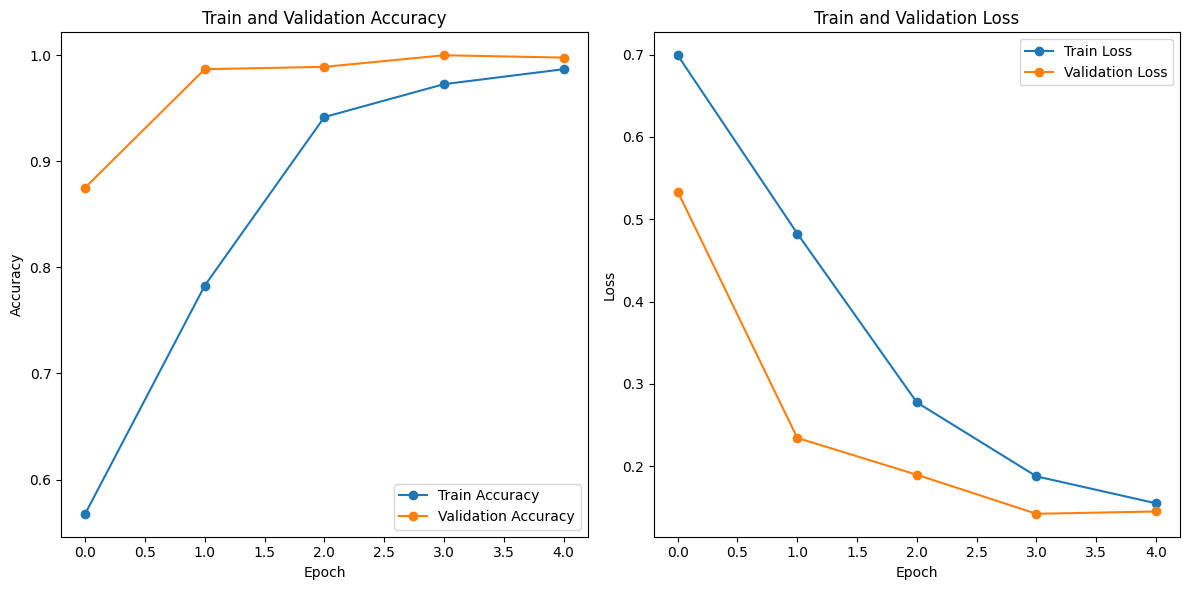

In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set hyperparameters for grid search
learning_rates = [1e-5, 2e-5, 3e-5]  # Example learning rates to test
batch_sizes = [8, 16, 32]  # Example batch sizes to test

# Lists to store training and validation metrics for each epoch and combination
train_losses_all = []
val_losses_all = []
train_accuracies_all = []
val_accuracies_all = []

best_accuracy = 0.0
best_learning_rate = 0.0
best_batch_size = 0
best_idx = None
idx = 0

# Iterate over learning rates and batch sizes
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with learning rate: {learning_rate}, batch size: {batch_size}")

        # Set the tokenizer and the model
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

        # Create a custom classifier head with dropout
        classifier = nn.Sequential(
            nn.Linear(model.config.hidden_size, 256),  # Modify the input and output dimensions as needed
            nn.BatchNorm1d(256),  # Batch normalization layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer with a dropout rate of 0.5 (adjust as needed)
            nn.Linear(256, 2)  # Modify the output dimensions as needed (2 for binary classification)
        )

        # Replace the classifier head in the BERT model with the custom classifier
        model.classifier = classifier

        # Send the model to the selected device (CPU or GPU)
        model.to(device)

        # Set hyperparameters
        num_epochs = 5  # You can adjust this as needed
        max_length = 128
        weight_decay = 0.01

        # Create the dataset and dataloader
        dataset = CustomDataset(df, tokenizer, max_length)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Split the data into train, validation, and test sets (70% train, 10% validation, 20% test)
        train_size = int(0.7 * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

        # Set the optimizer and loss function
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        loss_fn = torch.nn.CrossEntropyLoss()

        # Lists to store training and validation metrics for each epoch
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            total_train_loss = 0
            correct_predictions_train = 0
            total_train_samples = 0

            # Training phase
            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_train_loss += loss.item()

                logits = outputs.logits
                predicted_labels = torch.argmax(logits, dim=1)
                correct_predictions_train += torch.sum(predicted_labels == labels).item()
                total_train_samples += labels.size(0)

                loss.backward()
                optimizer.step()

            average_train_loss = total_train_loss / len(train_dataloader)
            train_accuracy = correct_predictions_train / total_train_samples

            # Validation phase
            model.eval()
            total_val_loss = 0
            correct_predictions_val = 0
            total_val_samples = 0

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask=attention_mask)
                    logits = outputs.logits

                    predicted_labels = torch.argmax(logits, dim=1)
                    correct_predictions_val += torch.sum(predicted_labels == labels).item()
                    total_val_samples += labels.size(0)

                    val_loss = loss_fn(logits, labels)
                    total_val_loss += val_loss.item()

            average_val_loss = total_val_loss / len(val_dataloader)
            val_accuracy = correct_predictions_val / total_val_samples

            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {average_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {average_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
            print("*****************************************************")

            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            # Check if the current validation accuracy is the best so far
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_learning_rate = learning_rate
                best_batch_size = batch_size
                best_idx = idx

                # Save the model with the best validation accuracy
                best_model = model.state_dict()

                # Save the entire model (including custom classifier head)
                best_model_path = f"best_model_lr_{best_learning_rate}_batch_{best_batch_size}.pt"
                torch.save(model, best_model_path)

            # Store the metrics for this combination
            train_losses_all.append(train_losses)
            val_losses_all.append(val_losses)
            train_accuracies_all.append(train_accuracies)
            val_accuracies_all.append(val_accuracies)

            idx += 1
            # Set the model back to training mode
            model.train()
        print("--------------------------------------------------------------------")

# Print the best hyperparameters and accuracy
print(f"Best Learning Rate: {best_learning_rate}")
print(f"Best Batch Size: {best_batch_size}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Plotting the best combination
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies_all[best_idx], label='Train Accuracy', marker='o')
plt.plot(val_accuracies_all[best_idx], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses_all[best_idx], label='Train Loss', marker='o')
plt.plot(val_losses_all[best_idx], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Save or display the plots
plt.tight_layout()
plt.show()

## EVALUATION

Evaluating and then printing the important metrics like precision and recall, support, f1 score along with confusion matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)

# Load the best model
best_model = torch.load(best_model_path)

test_df = pd.read_csv('/content/test_dataset.csv')

# Set the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the test data
test_inputs = tokenizer.batch_encode_plus(
    test_df[['premise', 'hypothesis']].values.tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

test_input_ids = test_inputs['input_ids'].to(device)
test_attention_mask = test_inputs['attention_mask'].to(device)
test_labels = torch.tensor(test_df['label'].tolist()).to(device)

# Evaluate the model on the test dataset
best_model.eval()
with torch.no_grad():
    outputs = best_model(test_input_ids, attention_mask=test_attention_mask)
    logits = outputs.logits

    predicted_labels = torch.argmax(logits, dim=1)
    predicted_labels = predicted_labels.cpu().numpy()
    test_labels = test_labels.cpu().numpy()

# Calculate TP, TN, FP, FN
TP = np.sum((test_labels == 1) & (predicted_labels == 1))
TN = np.sum((test_labels == 0) & (predicted_labels == 0))
FP = np.sum((test_labels == 0) & (predicted_labels == 1))
FN = np.sum((test_labels == 1) & (predicted_labels == 0))

# Print the confusion matrix
print("Confusion Matrix:")
print("          Predicted 0   Predicted 1")
print(f"Actual 0     {TN}            {FP}")
print(f"Actual 1     {FN}            {TP}")

TP=TP.item()
TN=TN.item()
FP=FP.item()
FN=FN.item()

precision = TP/(TP+FP)
recall = TP/(TP+FN)
accuracy = (TP+TN)/(TP+TN+FP+FN)
f1 = (2*precision*accuracy)/(precision+accuracy)

print("Classification report: ")
print('Precision: ', precision)
print('Recall: ', recall)
print('Test accuracy: ', accuracy)
print('f1 score: ', f1)


Confusion Matrix:
          Predicted 0   Predicted 1
Actual 0     315            2
Actual 1     1            63
Classification report: 
Precision:  0.9692307692307692
Recall:  0.984375
Test accuracy:  0.9921259842519685
f1 score:  0.980544747081712


### Defining a function to test the model on user entered premise and hypothesis

In [ ]:
device = torch.device('cpu')
best_model.to(device)

# Input premise and hypothesis (modify as needed)
premise = input("Enter the premise: ")
hypothesis = input("Enter the hypothesis: ")

# Tokenize and encode the input
inputs = tokenizer(premise, hypothesis, return_tensors="pt")

# Make the prediction
with torch.no_grad():
    logits = best_model(**inputs).logits

# Determine the predicted class
predicted_class = torch.argmax(logits, dim=1).item()

# Map the predicted class to human-readable labels
class_labels = ["Not Satisfying", "Satisfying"]
predicted_label = class_labels[predicted_class]

# Print the prediction
print(f"Prediction: {predicted_label}")

Enter the premise: Sanjana has been studying very hard for her exams
Enter the hypothesis: Sanjana will get good scores in her exams
Prediction: Satisfying
